BCI Sample Size Determination (SSD)

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import special

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# M = 5 # iterations
# Ns = [4, 8, 12, 16, 20] # number of subjects
# Ts = [20, 36, 65] # number of trials

M = 1 # iterations
n_subjects = [4] # number of subjects
n_trials = [20] # number of trials

n_samples = 5000
n_chains = 3
n_tune = 500

M: 0	 Ns: 4	 T: 20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [α, σ_α, μ_φ]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:10<00:00, 1634.03draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7017916439815931, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


delta: 3.027657185046979
ALC: 3.027657185046979


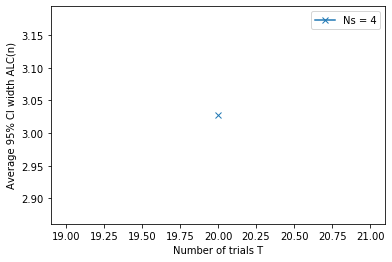

In [3]:
for Ns in n_subjects:
    ALCs = []
    for T in n_trials:
        ALC = 0
        for m in range(M):
            print("M: "+str(m)+"\t Ns: "+str(Ns)+"\t T: "+str(T))
            
            # draw parameters theta hat from sampling prior
            # draw dataset D^(n) from sampling distribution
            with pm.Model() as model:
                # group level parameters - a single value for mean and std
                group_level_mean_prob = pm.Uniform('μ_φ', lower=0.55, upper=0.95)
                group_level_mean_logit = pm.Deterministic('μ_α', pm.math.logit(group_level_mean_prob))
                group_level_std_logit = pm.Uniform('σ_α', lower=0.2, upper=1.2)
                
                # subject level parameters - a vector of size Ns
                subject_level_accuracy_logit = pm.Normal('α', mu=group_level_mean_logit,
                                                         sd=group_level_std_logit, shape=Ns)
                subject_level_accuracy_prob = pm.Deterministic('φ', pm.math.invlogit(subject_level_accuracy_logit))
                
                # sample the subject level accuracies
                trace = pm.sample(n_samples, chains=n_chains, tune=n_tune, discard_tuned_samples=True)
            
            # compute delta(D^(n)) using Baye's rule (via MCMC)
            # generate data for each subject
            trace_np = pd.DataFrame(trace['α']).to_numpy() # 15000 x Ns array of subject-level accuracies
#             data = np.empty([n_samples*n_chains, Ns])
#             for i in range(trace_np.shape[0]):
#                 for j in range(trace_np.shape[1]):
#                     # draw from a binomial distribution given phi and T
#                     y = pm.Binomial.dist(n=T, p=subject_accuracy)
#                     # calculate the accuracy across all trials
#                     data[i,j] = np.mean(y.random(size=T) / T)
            
            # take mean across all Ns subjects --> vector of 15000
            group_level_mean_logit_hat = np.mean(trace_np, axis=1)
            # compute 95% CI
            delta = np.percentile(group_level_mean_logit_hat, 97.5) - np.percentile(group_level_mean_logit_hat, 2.5)
            print("delta:", delta)

            # approximate ALC
            ALC += delta
        ALC /= M
        print("ALC:", ALC)
        ALCs.append(ALC)
    plt.plot(T, ALCs, marker='x', label='Ns = '+str(Ns))

plt.xlabel('Number of trials T')
plt.ylabel('Average 95% CI width ALC(n)')
plt.legend()
plt.show()

In [4]:
ALCs

[3.027657185046979]

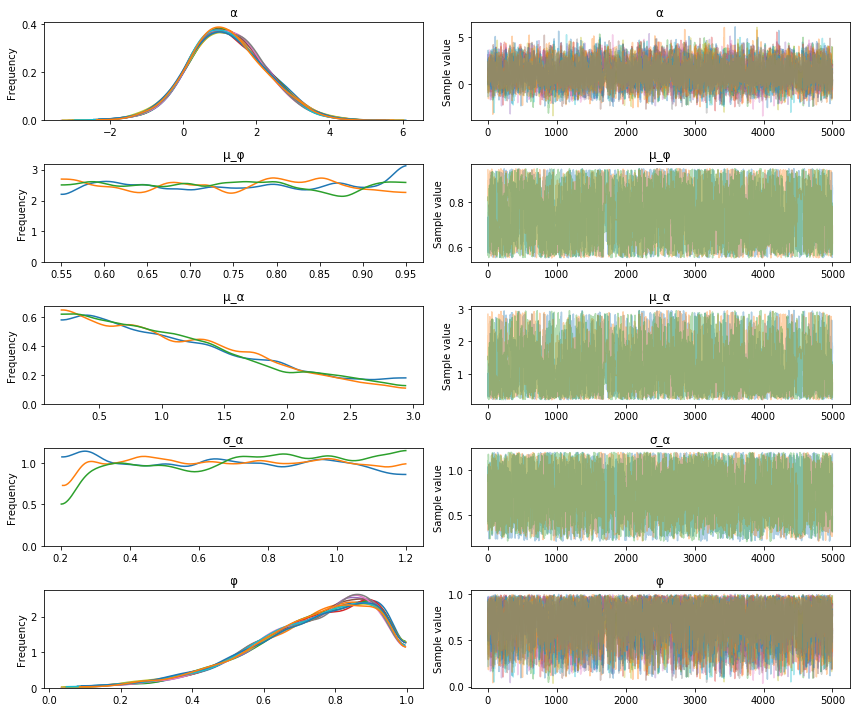

In [5]:
pm.traceplot(trace);

In [6]:
print("55% accuracy = " + str(special.logit(0.55)))
print("95% accuracy = " + str(special.logit(0.95)))
print()

def print_alc_effect(alc, prob):
    print("For ALC = " + str(alc) + ":")
    print("CI Range in probability scale for " + str(round(prob*100)) + "%")
    print("= %.2f - %.2f = %.2f" % (prob * 100,
                                    special.expit(special.logit(prob) - alc) * 100,
                                    (prob - special.expit(special.logit(prob) - alc)) * 100))
    print()

print_alc_effect(3, 0.95)
print_alc_effect(3, 0.55)
print_alc_effect(1, 0.95)
print_alc_effect(1, 0.55)

print_alc_effect(ALC, 0.95)
print_alc_effect(ALC, 0.55)

55% accuracy = 0.2006706954621514
95% accuracy = 2.9444389791664394

For ALC = 3:
CI Range in probability scale for 95%
= 95.00 - 48.61 = 46.39

For ALC = 3:
CI Range in probability scale for 55%
= 55.00 - 5.74 = 49.26

For ALC = 1:
CI Range in probability scale for 95%
= 95.00 - 87.48 = 7.52

For ALC = 1:
CI Range in probability scale for 55%
= 55.00 - 31.02 = 23.98

For ALC = 3.027657185046979:
CI Range in probability scale for 95%
= 95.00 - 47.92 = 47.08

For ALC = 3.027657185046979:
CI Range in probability scale for 55%
= 55.00 - 5.59 = 49.41



In [7]:
trace_np.shape

(15000, 4)

In [8]:
y = pm.Binomial.dist(n=20, p=0.564146)
y.random(size=20)

array([ 8, 11, 13, 12,  8, 11, 12, 13, 11,  9,  8, 11, 12, 11, 11, 15,  8,
       10, 13, 16])

In [ ]:
data = np.empty([n_samples*n_chains, Ns])
for i in range(trace_np.shape[0]):
    for j in range(trace_np.shape[1]):
        # draw from a binomial distribution given phi and T
        y = pm.Binomial.dist(n=T, p=0.564146)
        # calculate the accuracy across all trials
        data[i,j] = np.mean(y.random(size=T) / T)